# Neural Networks with Tensorflow

We are going to train a Neural Networks on the Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But we will flatten them to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset.

<img src='https://drive.google.com/uc?id=16TqEl9ESfXYbUpVafXD6h5UpJYGKfMxE' width="500" height="200">

The goal is to run at least 3 experiments and get a model that can achieve 80% accuracy with not much overfitting on this dataset.

Some assert statements have been added to verify the expected outputs are correct. If it doesn't throw an error, this means the implementation is behaving as expected.

# 1. Import Required Packages

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import os.path
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 2. Download Dataset

We will store the dataset into your personal Google Drive.


[2.1] Mount Google Drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


[2.2] Create a folder called `DL_ASG_1` on your Google Drive at the root level

In [3]:
! mkdir -p /content/gdrive/MyDrive/DL_ASG_1

[2.3] Navigate to this folder

In [5]:
%cd /content/gdrive/MyDrive/DL_ASG_1

/content/gdrive/MyDrive/DL_ASG_1


[2.4] Dowload the dataset files to your Google Drive if required

In [6]:
def download_file(url):
    path = url.split('/')[-1]
    if os.path.isfile(path):
        print (f"{path} already exists")
    else:
      r = requests.get(url, stream=True)
      with open(path, 'wb') as f:
          total_length = int(r.headers.get('content-length'))
          print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))
          for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
              if chunk:
                  f.write(chunk)

url_list = [
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
]

for url in url_list:
    download_file(url)

kmnist-train-imgs.npz already exists
kmnist-train-labels.npz already exists
kmnist-test-imgs.npz already exists
kmnist-test-labels.npz already exists


[2.5] List the content of the folder and confirm files have been dowloaded properly

In [7]:
! ls

checkpoints	      kmnist-test-labels.npz  kmnist-train-labels.npz
kmnist-test-imgs.npz  kmnist-train-imgs.npz   logs


# 3. Load Data

[3.1] Create 2 variables called `img_height` and `img_width` that will both take the value 28

In [8]:
# Create variable which [contains/represents] the height of the image
img_height = 28
# Create variable which [contains/represents] the width of the image
img_width = 28

[3.2] Create a function that loads a .npz file using numpy and return the content of the `arr_0` key

In [9]:
def load(f):
    return np.load(f)['arr_0']

[3.3] Load the 4 files saved on your Google Drive into their respective variables: x_train, y_train, x_test and y_test

In [10]:
# Load the training images
x_train = load("kmnist-train-imgs.npz")
# Load the testing images
x_test = load("kmnist-test-imgs.npz") 
# Load the training labels
y_train = load("kmnist-train-labels.npz")
# Load the testing labels
y_test = load("kmnist-test-labels.npz")

[3.4] Using matplotlib display the first image from the train set and its target value

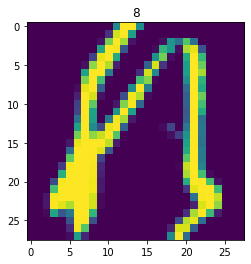

In [11]:
# Show the first image from the train set
plt.imshow(x_train[0])
# Display the target value for the first image from the train set as the title
plt.title(y_train[0])
# Display the plot
plt.show()

# 4. Prepare Data

[4.1] Reshape the images from the training and testing set to have the channel dimension last. The dimensions should be: (row_number, height, width, channel)

In [12]:
# Reshape the images from the training set to have 1 channel (greyscale)
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
# Reshape the images from the testing set to have 1 channel (greyscale)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)

[4.2] Cast `x_train` and `x_test` into `float32` decimals

In [13]:
# Cast x_train to float32
x_train = x_train.astype('float32')
# Cast x_test to float32
x_test = x_test.astype('float32')

[4.3] Standardise the images of the training and testing sets. Originally each image contains pixels with value ranging from 0 to 255. after standardisation, the new value range should be from 0 to 1.

In [14]:
# Standardise the training set images
x_train = x_train / 255.0
# Standardise the testing set images
x_test = x_test / 255.0

[4.4] Create a variable called `num_classes` that will take the value 10 which corresponds to the number of classes for the target variable

In [15]:
# Create a variable that will take the value corresponding to the number of classes in the target variable
num_classes = len(np.unique(y_train))

[4.5] Convert the target variable for the training and testing sets to a binary class matrix of dimension (rows, num_classes).

For example:
- class 0 will become [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
- class 1 will become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 
- class 5 will become [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 
- class 9 will become [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 

In [16]:
# Convert the target variable for train set to a binary class matrix (rows = y_train??, num_classes = 10)
y_train = keras.utils.to_categorical(y_train, num_classes)
# Convert the target variable for test set to a binary class matrix (rows = y_train??, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 5. Define Neural Networks Architecure

[5.1] Set the seed for Tensorflow Keras



In [17]:
keras.utils.set_random_seed(1)

[5.2] Define the architecture of your Neural Networks and save it into a variable called `model`

In [18]:
##### EXPERIMENT 1 ####
# Creating a Sequential Model to add the layers to
model1 = keras.Sequential()
# Adding input layer
model1.add(Flatten(input_shape=(28,28)))        # input layer (784 neurons)
# Adding hidden layer
model1.add(Dense(256, activation='relu'))       # hidden layer (256 neurons)
# Adding output layer
model1.add(Dense(10, activation='softmax'))     # output layer (10 neurons - Each represnts probabillity of image being one of the 10 classes)


#### EXPERIMENT 2 ####
# Creating a Sequential Model to add the layers to
model2 = keras.Sequential()
# Adding input layer
model2.add(Flatten(input_shape=(28,28)))        # input layer (784 neurons)
# Adding dropout
model2.add(Dropout(0.2))
# Adding hidden layers
model2.add(Dense(500, activation='relu'))       # first hidden layer (500 neurons)
model2.add(Dense(250, activation='relu'))       # second hidden layer (250 neurons)
model2.add(Dense(100, activation='relu'))       # third hidden layer (100 neurons)
# Adding output layer
model2.add(Dense(10, activation='softmax'))     # output layer (10 neurons - Each represnts probabillity of image being one of the 10 classes)


#### EXPERIMENT 3 ####
# Creating a Sequential Model to add the layers to
model3 = keras.Sequential()
# Adding input layer
model3.add(Flatten(input_shape=(28,28)))        # input layer (784 neurons)
# Adding dropout on visable layer
model3.add(Dropout(0.2))
# Adding hidden layers
model3.add(Dense(500, activation='relu'))       # first hidden layer (500 neurons)
model3.add(Dense(250, activation='relu'))       # second hidden layer (250 neurons)
model3.add(Dense(100, activation='relu'))       # third hidden layer (100 neurons)
# Adding dropout on hidden layer
model3.add(Dropout(0.3))
# Adding output layer
model3.add(Dense(10, activation='softmax'))     # output layer (10 neurons - Each represnts probabillity of image being one of the 10 classes)

[5.2] Print the summary of your model

In [19]:
# Print summary of model 1
model1.summary()
# Print summary of model 2
model2.summary()
# Print summary of model 2
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)          

# 6. Train Neural Networks

[6.1] Create 2 variables called `batch_size` and `epochs` that will  respectively take the values 128 and 500

In [20]:
# Create variable for batch size
batch_size = 128
# Create varibale for number of epochs
epochs = 500

[6.2] Compile your model with the appropriate loss function, the optimiser of your choice and the accuracy metric

In [21]:
# Compile model 1
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile model 2
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Compile model 3
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[6.3] Fit your model using the number of epochs defined. SAve the ouput to a variable called `history`. You can set up some callbacks if you wish.

In [22]:
history1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/500
375/375 [==============================] - 4s 9ms/step - loss: 0.4846 - accuracy: 0.8565 - val_loss: 0.3042 - val_accuracy: 0.9119
Epoch 2/500
375/375 [==============================] - 3s 9ms/step - loss: 0.2341 - accuracy: 0.9330 - val_loss: 0.2251 - val_accuracy: 0.9348
Epoch 3/500
375/375 [==============================] - 3s 9ms/step - loss: 0.1616 - accuracy: 0.9535 - val_loss: 0.1937 - val_accuracy: 0.9446
Epoch 4/500
375/375 [==============================] - 3s 9ms/step - loss: 0.1184 - accuracy: 0.9665 - val_loss: 0.1730 - val_accuracy: 0.9495
Epoch 5/500
375/375 [==============================] - 3s 9ms/step - loss: 0.0888 - accuracy: 0.9760 - val_loss: 0.1668 - val_accuracy: 0.9520
Epoch 6/500
375/375 [==============================] - 3s 9ms/step - loss: 0.0662 - accuracy: 0.9830 - val_loss: 0.1565 - val_accuracy: 0.9559
Epoch 7/500
375/375 [==============================] - 3s 8ms/step - loss: 0.0499 - accuracy: 0.9882 - val_loss: 0.1589 - val_accuracy: 0.9557

In [23]:
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/500
375/375 [==============================] - 7s 17ms/step - loss: 0.4495 - accuracy: 0.8623 - val_loss: 0.2253 - val_accuracy: 0.9320
Epoch 2/500
375/375 [==============================] - 6s 17ms/step - loss: 0.1920 - accuracy: 0.9419 - val_loss: 0.1569 - val_accuracy: 0.9553
Epoch 3/500
375/375 [==============================] - 6s 17ms/step - loss: 0.1286 - accuracy: 0.9597 - val_loss: 0.1442 - val_accuracy: 0.9561
Epoch 4/500
375/375 [==============================] - 6s 17ms/step - loss: 0.0925 - accuracy: 0.9704 - val_loss: 0.1564 - val_accuracy: 0.9559
Epoch 5/500
375/375 [==============================] - 6s 17ms/step - loss: 0.0751 - accuracy: 0.9758 - val_loss: 0.1342 - val_accuracy: 0.9622
Epoch 6/500
375/375 [==============================] - 6s 16ms/step - loss: 0.0574 - accuracy: 0.9802 - val_loss: 0.1483 - val_accuracy: 0.9614
Epoch 7/500
375/375 [==============================] - 6s 16ms/step - loss: 0.0483 - accuracy: 0.9842 - val_loss: 0.1379 - val_accuracy:

In [24]:
history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.2)

Epoch 1/500
375/375 [==============================] - 7s 17ms/step - loss: 0.5182 - accuracy: 0.8386 - val_loss: 0.2443 - val_accuracy: 0.9251
Epoch 2/500
375/375 [==============================] - 11s 30ms/step - loss: 0.2312 - accuracy: 0.9302 - val_loss: 0.1661 - val_accuracy: 0.9509
Epoch 3/500
375/375 [==============================] - 12s 33ms/step - loss: 0.1538 - accuracy: 0.9534 - val_loss: 0.1471 - val_accuracy: 0.9563
Epoch 4/500
375/375 [==============================] - 10s 28ms/step - loss: 0.1112 - accuracy: 0.9653 - val_loss: 0.1567 - val_accuracy: 0.9565
Epoch 5/500
375/375 [==============================] - 6s 17ms/step - loss: 0.0926 - accuracy: 0.9719 - val_loss: 0.1400 - val_accuracy: 0.9615
Epoch 6/500
375/375 [==============================] - 6s 17ms/step - loss: 0.0732 - accuracy: 0.9769 - val_loss: 0.1338 - val_accuracy: 0.9623
Epoch 7/500
375/375 [==============================] - 6s 17ms/step - loss: 0.0616 - accuracy: 0.9809 - val_loss: 0.1328 - val_accura

[6.4] Save the weights of your model

In [25]:
model1.save_weights('./checkpoints/my_checkpoint1')
model2.save_weights('./checkpoints/my_checkpoint2')
model3.save_weights('./checkpoints/my_checkpoint3')

# 7. Analyse Results

[7.1] Display the performance of your model on the training and testing sets

In [26]:
# Print results of model 1
print(model1.evaluate(x_train, y_train), model1.evaluate(x_test, y_test))

# Print results of model 2
print(model2.evaluate(x_train, y_train), model2.evaluate(x_test, y_test))

# Print results of model 3
print(model3.evaluate(x_train, y_train), model3.evaluate(x_test, y_test))

313/313 [==============================] - 1s 3ms/step - loss: 1.4714 - accuracy: 0.9052
[0.11644232273101807, 0.9921500086784363] [1.4713796377182007, 0.9052000045776367]
313/313 [==============================] - 1s 4ms/step - loss: 0.9766 - accuracy: 0.9388
[0.06432884931564331, 0.9949833154678345] [0.9766499996185303, 0.9387999773025513]
313/313 [==============================] - 1s 5ms/step - loss: 1.3996 - accuracy: 0.9362
[0.10257819294929504, 0.9947166442871094] [1.3995742797851562, 0.9362000226974487]


[7.2] Plot the learning curve of your model

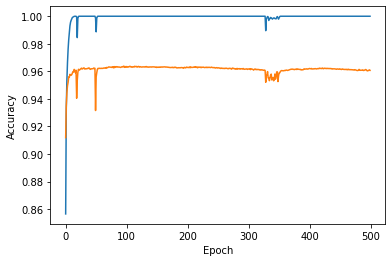

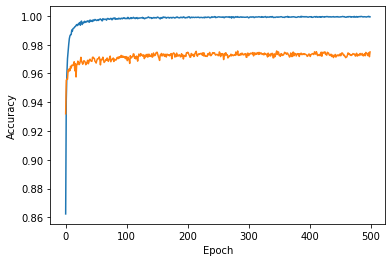

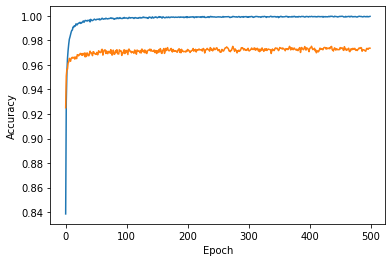

In [27]:
#### EXPERIMENT 1 ####
plt.plot(history1.history['accuracy'], label='training')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### EXPERIMENT 2 ####
plt.plot(history2.history['accuracy'], label='training')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### EXPERIMENT 3 ####
plt.plot(history3.history['accuracy'], label='training')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

[7.3] Display the confusion matrix on the testing set predictions

In [30]:
#### EXPERIMENT 1 ####
sparse_pred_test1 = model1.predict(x_test)
pred_test1 = np.argmax(sparse_pred_test1, 1)
y_test2 = np.argmax(y_test, 1)

confusion_mat1 = tf.math.confusion_matrix(pred_test1, y_test2, num_classes=10)
print(confusion_mat1)

#### EXPERIMENT 2 ####
sparse_pred_test2 = model2.predict(x_test)
pred_test2 = np.argmax(sparse_pred_test2, 1)
y_test2 = np.argmax(y_test, 1)

confusion_mat2 = tf.math.confusion_matrix(pred_test2, y_test2, num_classes=10)
print(confusion_mat2)

#### EXPERIMENT 3 ####
sparse_pred_test3 = model3.predict(x_test)
pred_test3 = np.argmax(sparse_pred_test3, 1)
y_test2 = np.argmax(y_test, 1)

confusion_mat3 = tf.math.confusion_matrix(pred_test3, y_test2, num_classes=10)
print(confusion_mat3)

313/313 [==============================] - 1s 4ms/step
tf.Tensor(
[[926   6  12   2  30   4   2   9  14   9]
 [  5 888   6   8  16  10   5  12  20  12]
 [  2  18 863  24   3  41  21  11  11  19]
 [  0   1  42 945  12   9   3   1  17   8]
 [ 15   8  13   3 871   7  13   9   3  12]
 [ 11   8  18   2   7 890   5   2   9   1]
 [  5  36   5   5  18  21 943  18   8   5]
 [ 17  10  14   3  11   3   5 901   3   6]
 [ 14  12  14   5  20  10   0  16 911  14]
 [  5  13  13   3  12   5   3  21   4 914]], shape=(10, 10), dtype=int32)
313/313 [==============================] - 2s 6ms/step
tf.Tensor(
[[964   1   8   0  18   3   4   4  10   6]
 [  1 920   5   6  15   5   5   6   8  14]
 [  1   8 881  13   2  13  10   5   5  14]
 [  0   0  50 967   7   7   2   1  14   4]
 [ 12   4   5   1 907   2   2   8   2   8]
 [  2   5  12   5   6 952   3   2   7   2]
 [  0  30   9   2  10  13 971  10   5  13]
 [ 11   4   7   2   6   2   1 955   1   5]
 [  7  13  11   2  25   1   2   6 948  11]
 [  2  15  12   2   